In [1]:
import os, sys
import pandas as pd
import glob
import numpy as np
from copy import deepcopy
import json
import csv
import matplotlib
from operator import itemgetter
import psutil
import plotly.express as px
import matplotlib.pyplot as plt
import math
from math import isnan
import numpy
import ntpath
import git
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import numpy as np
from boutiques.searcher import Searcher
from boutiques.puller import Puller
from github import Github
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
from PIL import ImageColor
from statistics import mean
from scipy.stats import ttest_ind
from statistics import mean
from mpl_toolkits.axes_grid1 import make_axes_locatable


inputsFolder = os.path.join(os.getcwd(), "..", "data")
outputsFolder = os.path.join(os.getcwd(), "..", "result")
if not os.path.exists(outputsFolder):
    os.mkdir(outputsFolder) 
    
figuresFolder = os.path.join(os.getcwd(), "..", "figures")
if not os.path.exists(figuresFolder):
    os.mkdir(figuresFolder) 
    
expertsFolder = os.path.join(inputsFolder, "Expert Comments")

recommender_DF_FN = os.path.join(outputsFolder, "Recommender DF v4.xlsx")
recommender_JSON_FN = recommender_DF_FN.replace(".xlsx", ".json")

RECOMMENDER_DF_STATISTICS = {
    "Num of all items":0,
    #100% success
    "Num of Assessed By Experts": 0,       #Listed in Experts assessment
    "Num of Not Assessed By Experts": 0,   #Not listed in Experts assessment
    "Num of Success Predicted By Experts": 0,
    
    "Num of Tests": 0,
    "Num of Tests is failed": 0,
    "Num of Tests is wrong data or wrong format": 0,
    "Num of Tests is not available": 0,
    "Num of Tests is pipeline issue": 0,
    "Num of Tests is success": 0,
    "Num of Tests is not tested": 0,
    
    "Num of 100% Assessed Success": 0,
    
    "Num of Cells With Comment": 0,
    "Num of Total Comments": 0,
    "Average Expert Comments per Cell": 0,
}

DATA_TEMPLATE = {
    "EXPERT_COMMENTS": [],
    "EXPERTS_COMMENTED_SUCCESS": [],
    "NUM_OF_EXPERT_COMMENTS": 0,
    "EXPERT_CONFIDENCE_LIST": [],
    "CONFIDENCE_RATING": 0,
    "CONFIDENCE_SUCCESS_RATING": 0,
    "EXECUTION_RESULT_DETAILS": "",
    "EXECUTION_RESULT_BRIEF": "",
    "FRACTION_RATE_SUCCESS_OVER_ALL": 0,
    "FRACTION_RATE_SUCCESS_OVER_COMMENTED": 0,
    
}

executionResult_DF_FN = os.path.join(inputsFolder, "Provenance Records.xlsx")
REAL_TESTS_RESULT_CODES = {
    'failed': 5, 
    'wrong data': 4, 
    'wrong format': 4, 
    'not available': 3, 
    'pipeline issue': 2,
    'success': 1
    #' ': 0
    }

#The file that stores the confidence level of Experts
surveyInputFile = os.path.join(inputsFolder, "Experts Assessment.csv")
asessedPipelinesFile = os.path.join(inputsFolder, "Assessed Pipelines.txt")
assessedDatasetFile = os.path.join(inputsFolder, "Assessed Datasets.txt")

#To rate the confidence of the Experts
confidenceRatings = {'No idea':1, 'Some idea': 2, 'Good knowledge': 3, 'Expert': 4}

#TO store the Indexes for Pipelines and Datasets
pipelineIndexTable_DF_FN = os.path.join(outputsFolder, "Pipeline Index Table v4.xlsx")
datasetIndexTable_DF_FN = os.path.join(outputsFolder, "Dataset Index Table v4.xlsx")
confidenceEvaluationReport_DF_FN = os.path.join(outputsFolder, "Confidence Evaluation Report.csv")
fractionRateReport_DF_FN = os.path.join(outputsFolder, "Fraction Rate Report.csv")

pipelineDescriptors_FN = os.path.join(inputsFolder, "CONP Descriptors", "all_descriptors.json")

alsModelInput_DF_FN = os.path.join(inputsFolder, "ALS Model", 'ALS Model Input.csv')
alsModel_FN = os.path.join(inputsFolder, "ALS Model", 'All Predicted Values Test Set.csv')

#The Global Dataframe that stores everything
recommender_DF = pd.DataFrame()


#Loads data from DataFrame (recommender_DF_FN) to recommender_DF
def loadRecommenderDataFrame(): 
    global recommender_DF
    
    #Load JSON to DataFrame
    recommender_DF = pd.read_json(recommender_JSON_FN)
    recommender_DF.index.name = 'Pipelines/Datasets'
    recommender_DF = recommender_DF.sort_values(by=['Pipelines/Datasets'])
    recommender_DF = recommender_DF.reindex(sorted(recommender_DF.columns), axis=1)

def saveRecommenderDataFrame():
    global recommender_DF
    if recommender_DF.empty:
        return
    
    recommender_DF.index.name = 'Pipelines/Datasets'
    recommender_DF = recommender_DF.sort_values(by=['Pipelines/Datasets'])
    recommender_DF = recommender_DF.reindex(sorted(recommender_DF.columns), axis=1)
    if not os.path.exists(outputsFolder):
        os.mkdir(outputsFolder) 
    recommender_DF.to_excel(recommender_DF_FN) 
    
    #Write JSON to file
    with open(recommender_JSON_FN, 'w') as outfile:
        #json.dump(recommender_Dict, outfile, indent = 4)
        json.dump(recommender_DF.to_dict(), outfile, indent = 4)

def saveReportFile(functionName, fileContentStringList):
    reportFileName = os.path.join(outputsFolder, functionName + ".txt")
    reportFileHandler = open(reportFileName, 'w')
    for item in fileContentStringList:
        if type(item) == list:
            item = '[' + ''.join(str(e)+', ' for e in item) + ']'
        #print(item)
        reportFileHandler.write(item + "\n")
    reportFileHandler.close()

    
def saveReportFileJson(functionNameJson, fileContent):
    with open(os.path.join(outputsFolder, functionNameJson), 'w') as outfile:
        json.dump(fileContent, outfile, indent = 4)
        outfile.close()

    
def indexDataFrame_v4(dataFrame):
    if dataFrame.empty:
        return
    
    #Get Indexes for Pipelines
    df = pd.read_excel(pipelineIndexTable_DF_FN)
    df = df.set_index(df.columns[0])
    
    keys = df.index.values.tolist()
    values = df.values.tolist()
    
    pipelineIndexDict = dict()
    for i in range(0, len(keys)):
        pipelineIndexDict[keys[i]] = values[i][0]
    
    #Get Indexes for Datasets
    df = pd.read_excel(datasetIndexTable_DF_FN)
    df = df.set_index(df.columns[0])
    
    keys = df.index.values.tolist()
    values = df.values.tolist()
    
    datasetIndexDict = dict()
    for i in range(0, len(keys)):
        datasetIndexDict[keys[i]] = values[i][0]

    #Index the main data Frame
    dataFrame.rename(columns=datasetIndexDict, inplace=True)
    dataFrame.rename(index=pipelineIndexDict, inplace=True)

    return dataFrame


def getPipelineIndex(pipelineName):
    #Get Indexes for Pipelines
    df = pd.read_excel(pipelineIndexTable_DF_FN)
    df = df.set_index(df.columns[0])
    return df.loc[pipelineName]

def getPipelinesIndexDict():
    #Get Indexes for Pipelines
    df = pd.read_excel(pipelineIndexTable_DF_FN)
    df = df.set_index(df.columns[0])

    keys = df.index.values.tolist()
    values = df.values.tolist()
    
    pipelineIndexDict = dict()
    for i in range(0, len(keys)):
        pipelineIndexDict[keys[i]] = values[i][0]
    return pipelineIndexDict

def getDatasetIndex(datasetName):
    #Get Indexes for Datasets
    df = pd.read_excel(datasetIndexTable_DF_FN)
    df = df.set_index(df.columns[0])
    return df.loc[datasetName]

def getDatasetsIndexDict():
    #Get Indexes for Datasets
    df = pd.read_excel(datasetIndexTable_DF_FN)
    df = df.set_index(df.columns[0])

    keys = df.index.values.tolist()
    values = df.values.tolist()
    
    datasetIndexDict = dict()
    for i in range(0, len(keys)):
        datasetIndexDict[keys[i]] = values[i][0]

    return datasetIndexDict

def showFigure_Ploly_v4(
    processingFunction, 
    useIndex = False,
    colorScale=[[0, "red"], [0.5 , "white"], [1, "green"]], 
    figureTitle=None,
    result_DF_FN = None):
    
    global recommender_DF
    if recommender_DF.empty:
        loadRecommenderDataFrame()
    
    if not processingFunction:
        return
    
    temporary_DF = pd.DataFrame(index=recommender_DF.index.tolist(), columns=recommender_DF.columns.tolist())
    
    for rowName in recommender_DF.index:
        for columnName in recommender_DF.columns:
            temporary_DF.loc[rowName, columnName] = processingFunction(recommender_DF.loc[rowName, columnName])
    
    if useIndex is True:
        temporary_DF = indexDataFrame_v4(temporary_DF)
    
    if result_DF_FN:
        if '.xlsx' in result_DF_FN:
            temporary_DF.to_excel(result_DF_FN)
        elif '.csv' in result_DF_FN:
            temporary_DF.to_csv(
                result_DF_FN, 
                sep=',', 
                encoding='utf-8')
        
    figure = px.imshow(temporary_DF, color_continuous_scale = colorScale)

    figure.update_layout(autosize=True)
    
    if figureTitle:
        figure.update_layout(title=figureTitle)
    '''
    figure.update_layout(
        font=dict(
            family="Arial",
            size=40
        )
    )'''
    
    figure.update_layout(coloraxis_showscale=False)
    
    #figure.show(block=False)
    return figure

def showFigure_Mtplotlib_v4___(
    processingFunction, 
    useIndex = False,
    colorScale=[[0, "red"], [0.5 , "white"], [1, "green"]], 
    figureTitle=None,
    result_DF_FN = None,
    colorbarTextPoints = None,
    colorbarTexts = None,
    colorbarTextRotation = 0):
    

    global recommender_DF
    if recommender_DF.empty:
        loadRecommenderDataFrame()
    
    if not processingFunction:
        return
    
    temporary_DF = pd.DataFrame(index=recommender_DF.index.tolist(), columns=recommender_DF.columns.tolist())
    
    for rowName in recommender_DF.index:
        for columnName in recommender_DF.columns:
            temporary_DF.loc[rowName, columnName] = 2 * processingFunction(recommender_DF.loc[rowName, columnName]) - 1  #Map (0, 1) to (-1, 1)
    
    if useIndex is True:
        temporary_DF = indexDataFrame_v4(temporary_DF)
    
    if result_DF_FN:
        if '.xlsx' in result_DF_FN:
            temporary_DF.to_excel(result_DF_FN)
        elif '.csv' in result_DF_FN:
            temporary_DF.to_csv(
                result_DF_FN, 
                sep=',', 
                encoding='utf-8')

    temporary_DF = temporary_DF.astype(float)
    
    figure = plt.figure(figsize=(15, 15))
    figure, ax = plt.subplots(figsize=(15, 15))
    
    sns.heatmap(
        temporary_DF, 
        cmap=ListedColormap(colorScale), 
        vmin=-1, 
        vmax=1, 
        #linewidths=.5,
        cbar=True,
        cbar_kws={
            'pad': 0.05, 
            'orientation': 'horizontal',
            #'orientation': 'vertical',
            "shrink": 0.5
        },
        ax = ax,
        square=True, #Square the tiles
        )
    
    #ax.set_aspect('equal') #Square the tiles
    
    if figureTitle:
        plt.title(title=figureTitle)
        
    plt.yticks(
        np.arange(0.5, len(temporary_DF.index), 1), 
        temporary_DF.index, 
        rotation = 0)#,fontsize='small')

    plt.xticks(
        np.arange(0.5, len(temporary_DF.columns), 1),
        temporary_DF.columns, 
        rotation = 90)#, fontsize='small')

    #Update colorbar
    if colorbarTextPoints and colorbarTexts:
        #Get access to colorbar
        cbar = ax.collections[0].colorbar
        
        
        #Set font size of colorbar
        #cbar.ax.tick_params(labelsize=18)

        #Set ticks of colorbar (Texts)
        for index, item in enumerate(colorbarTextPoints):
            colorbarTextPoints[index] = 2 * colorbarTextPoints[index] - 1
        cbar.set_ticks(colorbarTextPoints)
        cbar.set_ticklabels(colorbarTexts)
        #cbar.ax.set_yticklabels(colorbarTexts, rotation = colorbarTextRotation)  #if 'orientation': 'vertical',
        cbar.ax.set_xticklabels(colorbarTexts, rotation = colorbarTextRotation, fontsize='small')  #if 'orientation': 'horizontal',

    
    plt.setp(ax.get_xticklabels(), horizontalalignment='right', fontsize='small')
    
    plt.show(block=False)
    plt.pause(1)
    plt.close()

    return figure

def showFigure_Mtplotlib_v4_(
    processingFunction, 
    useIndex = False,
    colorScale=[[0, "red"], [0.5 , "white"], [1, "green"]], 
    figureTitle=None,
    result_DF_FN = None,
    colorbarTextPoints = None,
    colorbarTexts = None,
    colorbarTextRotation = 0):
    

    global recommender_DF
    if recommender_DF.empty:
        loadRecommenderDataFrame()
    
    if not processingFunction:
        return
    
    temporary_DF = pd.DataFrame(index=recommender_DF.index.tolist(), columns=recommender_DF.columns.tolist())
    
    for rowName in recommender_DF.index:
        for columnName in recommender_DF.columns:
            #temporary_DF.loc[rowName, columnName] = 2 * processingFunction(recommender_DF.loc[rowName, columnName]) - 1  #Map (0, 1) to (-1, 1)
            temporary_DF.loc[rowName, columnName] = processingFunction(recommender_DF.loc[rowName, columnName])
    
    if useIndex is True:
        temporary_DF = indexDataFrame_v4(temporary_DF)
    
    if result_DF_FN:
        if '.xlsx' in result_DF_FN:
            temporary_DF.to_excel(result_DF_FN)
        elif '.csv' in result_DF_FN:
            temporary_DF.to_csv(
                result_DF_FN, 
                sep=',', 
                encoding='utf-8')

    temporary_DF = temporary_DF.astype(float)
    
    #temporary_DF.to_csv(os.path.join(outputsFolder, "showFigure_Mtplotlib_v4_.csv"))
    
    #figure = plt.figure(figsize=(20, 20))
    #figure, ax = plt.subplots(figsize=(18, 18))
    figure, ax = plt.subplots(1, 1, figsize=(12, 18), dpi=60)
    
    if colorbarTextPoints and colorbarTexts:
        cbar = True
    else:
        cbar = False
        
    ax = sns.heatmap(
        temporary_DF, 
        cmap=ListedColormap(colorScale), 
        vmin=0, 
        vmax=1, 
        #linewidths=.5,
        cbar=cbar,
        cbar_kws={
            'pad': 0.05, 
            #'orientation': 'horizontal',
            'orientation': 'vertical',
            "shrink": 0.5
        },
        ax = ax,
        square=True, #Square the tiles
        )
    
    
    cmap = ax.collections[0].cmap
    cmap.set_under('white')#Colour values less than vmin in white
    cmap.set_over('yellow')# colour valued larger than vmax in red
    
    #ax.set_aspect('equal') #Square the tiles
    
    if figureTitle:
        plt.title(title=figureTitle)
        
    plt.yticks(
        np.arange(0.5, len(temporary_DF.index), 1), 
        temporary_DF.index, 
        rotation = 0,
        fontsize=22)

    plt.xticks(
        np.arange(0.5, len(temporary_DF.columns), 1),
        temporary_DF.columns, 
        rotation = 90,
        fontsize=22)
    
    plt.margins(0,0)
    
    #Update colorbar
    if colorbarTextPoints and colorbarTexts:
        #Get access to colorbar
        cbar = ax.collections[0].colorbar
        
        #Set font size of colorbar
        #cbar.ax.tick_params(labelsize=18)

        #Set ticks of colorbar (Texts)
        #for index, item in enumerate(colorbarTextPoints):
        #    colorbarTextPoints[index] = 2 * colorbarTextPoints[index] - 1
        cbar.set_ticks(colorbarTextPoints)
        cbar.set_ticklabels(colorbarTexts)
        #cbar.ax.set_yticklabels(colorbarTexts, rotation = colorbarTextRotation)  #if 'orientation': 'vertical',
        cbar.ax.set_yticklabels(colorbarTexts, rotation = colorbarTextRotation, fontsize=13)  #if 'orientation': 'horizontal',
        #cbar.set(size="5%", pad=0.05)
        cmap = cbar.cmap
        
        cmap.set_under('white')#Colour values less than vmin in white
        cmap.set_over('yellow')# colour valued larger than vmax in red
    
    #plt.setp(ax.get_xticklabels(), horizontalalignment='right', fontsize='small')
    
    plt.show(block=False)
    plt.pause(1)
    plt.close()

    return figure

def showFigure_Mtplotlib_v4(
    processingFunction, 
    useIndex = False,
    colorScale=[[0, "red"], [0.5 , "white"], [1, "green"]], 
    figureTitle=None,
    result_DF_FN = None,
    colorbarTextPoints = None,
    colorbarTexts = None,
    colorbarTextRotation = 0):
    

    global recommender_DF
    if recommender_DF.empty:
        loadRecommenderDataFrame()
    
    if not processingFunction:
        return
    
    temporary_DF = pd.DataFrame(index=recommender_DF.index.tolist(), columns=recommender_DF.columns.tolist())
    
    for rowName in recommender_DF.index:
        for columnName in recommender_DF.columns:
            #temporary_DF.loc[rowName, columnName] = 2 * processingFunction(recommender_DF.loc[rowName, columnName]) - 1  #Map (0, 1) to (-1, 1)
            temporary_DF.loc[rowName, columnName] = processingFunction(recommender_DF.loc[rowName, columnName])
    
    if useIndex is True:
        temporary_DF = indexDataFrame_v4(temporary_DF)
    
    if result_DF_FN:
        if '.xlsx' in result_DF_FN:
            temporary_DF.to_excel(result_DF_FN)
        elif '.csv' in result_DF_FN:
            temporary_DF.to_csv(
                result_DF_FN, 
                sep=',', 
                encoding='utf-8')

    temporary_DF = temporary_DF.astype(float)
    #temporary_DF.to_csv(os.path.join(outputsFolder, "showFigure_Mtplotlib_v4.csv"))
    
    
    #figure = plt.figure(figsize=(20, 20))
    #figure, ax = plt.subplots(figsize=(18, 18))
    
    #figure, (figureAxis, colorbarAxis) = plt.subplots(1, 2, figsize=(12, 18), dpi=60)
    
    
    #https://stackoverflow.com/questions/13784201/matplotlib-2-subplots-1-colorbar
    figure, figureAxis = plt.subplots(figsize=(12, 18), dpi=60)
    figureAxis.set_aspect('auto')
    
    yticks = temporary_DF.index
    xticks = temporary_DF.columns
    temporary_DF = temporary_DF.to_numpy()
    
    img = plt.imshow(temporary_DF, cmap=ListedColormap(colorScale), interpolation='nearest')
    
    
    if figureTitle:
        plt.title(title=figureTitle)
        
    plt.yticks(
        np.arange(0.5, len(yticks), 1), 
        yticks, 
        rotation = 0,
        fontsize=15)

    plt.xticks(
        np.arange(0.5, len(xticks), 1),
        xticks, 
        rotation = 90,
        fontsize=15,
        horizontalalignment='right')
    
    figureAxis.tick_params(axis='both', labelsize=22)
    
    plt.margins(0,0)
    
    figureAxis.set_aspect('auto')

    if colorbarTextPoints and colorbarTexts:
        '''
        divider = make_axes_locatable(figureAxis)
        cax1 = divider.append_axes("right", size="5%", pad=0.5)
        colours = img.cmap(img.norm(np.unique(temporary_DF)))
        
        cbar = figure.colorbar(img, cmap=colours[0:1],  cax=cax1)

        colorbarTextPoints = [ round(item, 2) for item in colorbarTextPoints ]
        
        #cbar = figure.colorbar(img, ax=figureAxis, cax=cbar, orientation='vertical', ticks=colorbarTextPoints)
        cbar.set_ticks(colorbarTextPoints)
        cbar.set_ticklabels(colorbarTexts)
        cbar.ax.tick_params(labelsize=13)
        
        print(divider.get_position())
        '''
        
        cbar = plt.colorbar(img, pad=0.03, shrink=0.5, ticks=colorbarTextPoints)
        cbar.set_ticks(colorbarTextPoints)
        #cbar.xaxis.set_ticks(colorbarTextPoints)
        cbar.ax.set_yticklabels(colorbarTexts)
        
        #plt.colorbar(shrink=0.5)
        
    plt.show(block=False)
    plt.pause(1)
    plt.close()
    
    return figure

def showFigure_Mtplotlib_v4_For_Percentage(
    processingFunction, 
    useIndex = False,
    colorScale=[[0, "red"], [0.5 , "white"], [1, "green"]], 
    figureTitle=None,
    result_DF_FN = None,
    colorbarTextPoints = None,
    colorbarTexts = None,
    colorbarTextRotation = 0):
    

    global recommender_DF
    if recommender_DF.empty:
        loadRecommenderDataFrame()
    
    if not processingFunction:
        return
    
    temporary_DF = pd.DataFrame(index=recommender_DF.index.tolist(), columns=recommender_DF.columns.tolist())
    
    for rowName in recommender_DF.index:
        for columnName in recommender_DF.columns:
            temporary_DF.loc[rowName, columnName] = processingFunction(recommender_DF.loc[rowName, columnName])
    
    if useIndex is True:
        temporary_DF = indexDataFrame_v4(temporary_DF)
    
    if result_DF_FN:
        if '.xlsx' in result_DF_FN:
            temporary_DF.to_excel(result_DF_FN)
        elif '.csv' in result_DF_FN:
            temporary_DF.to_csv(
                result_DF_FN, 
                sep=',', 
                encoding='utf-8')

    temporary_DF = temporary_DF.astype(float)

    #https://stackoverflow.com/questions/13784201/matplotlib-2-subplots-1-colorbar
    figure, figureAxis = plt.subplots(figsize=(14, 18), dpi=60)
    figureAxis.set_aspect('auto')
    
    yticks = temporary_DF.index
    xticks = temporary_DF.columns
    temporary_DF = temporary_DF.to_numpy()
    
    img = plt.imshow(temporary_DF, cmap=ListedColormap(colorScale), interpolation='nearest')
    
    
    if figureTitle:
        plt.title(title=figureTitle)
        
    plt.yticks(
        np.arange(0.5, len(yticks), 1), 
        yticks, 
        rotation = 0,
        fontsize=15)

    plt.xticks(
        np.arange(0.5, len(xticks), 1),
        xticks, 
        rotation = 90,
        fontsize=15,
        horizontalalignment='right')
    
    figureAxis.tick_params(axis='both', labelsize=22)
    
    plt.margins(0,0)
    
    figureAxis.set_aspect('auto')

    if colorbarTextPoints and colorbarTexts:
        cbar = plt.colorbar(img, pad=0.03, shrink=0.5, ticks=colorbarTextPoints)
        cbar.set_ticks(colorbarTextPoints)
        cbar.ax.set_yticklabels(colorbarTexts, fontsize=20)
        
    plt.show(block=False)
    plt.pause(1)
    plt.close()
    
    return figure


def generateReportDataFrame(fileName, columns, rows):

    #Get results from executionResult_DF_FN
    #confidenceEvaluation_DF = pd.DataFrame(columns=['Pipelines', "Datasets", "Status", "AVG_Confidence"])
    reportDataFrame = pd.DataFrame(columns=columns)
    
    
    for row in rows:
        reportDataFrame = reportDataFrame.append(
            pd.Series(
            row, 
            index=reportDataFrame.columns), ignore_index=True)
    
    #reportDataFrame.reset_index(drop=True, inplace=True)
    
    reportDataFrame.to_csv(
        fileName, 
        sep = ',', 
        encoding = 'utf-8',
        index = False)


In [2]:
def concatenateExpertComments_v4():
    global recommender_DF,outputsFolder, DATA_TEMPLATE, recommender_DF_FN
    
    #This block extract Pipeline, Dataset that at least 1 expert commented that are compatible. 
    listOfFiles = glob.glob(expertsFolder + os.path.sep + '*.csv')

    listOfPipelines = []
    listOfDatasets = []

    success_DS = deepcopy(DATA_TEMPLATE)
    success_DS["EXPERT_COMMENTS"] += ['+1']

    fail_DS = deepcopy(DATA_TEMPLATE)
    fail_DS["EXPERT_COMMENTS"] += ['-1']

    recommender_DF = pd.DataFrame()

    for inputFile in listOfFiles:

        new_DF = pd.read_csv(inputFile, index_col=0)   #Set first column as index

        #Adding row and columns to dataFrame
        for rowName in new_DF.index:
            if rowName.strip() not in listOfPipelines:
                listOfPipelines += [rowName.strip()]
            for columnName in new_DF.columns:
                if columnName.strip() not in listOfDatasets:
                    listOfDatasets += [columnName.strip()]
    
    columnList = [deepcopy(DATA_TEMPLATE) for x in range(len(listOfDatasets))]
    zipList = [deepcopy(columnList) for x in range(len(listOfPipelines))]
    recommender_DF = pd.DataFrame(zipList, index =listOfPipelines, columns=listOfDatasets)
    
    #saveRecommenderDataFrame() 

    for inputFile in listOfFiles:
        expertsName = ntpath.basename(inputFile).split('-')[0].strip()
        new_DF = pd.read_csv(inputFile, index_col=0)   #Set first column as index

        #Adding row and columns to dataFrame
        for rowName in new_DF.index:
            for columnName in new_DF.columns:
                rowName = rowName.strip()
                columnName = columnName.strip()
                
                recommender_DF.loc[rowName,columnName]["NUM_OF_EXPERT_COMMENTS"] += 1
                if new_DF.loc[rowName,columnName] in ['x', 'X']:
                    recommender_DF.loc[rowName,columnName]["EXPERT_COMMENTS"] += ['+1']
                    recommender_DF.loc[rowName,columnName]["EXPERTS_COMMENTED_SUCCESS"] += [expertsName]
                else:
                    recommender_DF.loc[rowName,columnName]["EXPERT_COMMENTS"] += ['-1']
    
    saveRecommenderDataFrame()   
        
    print("concatenateExpertComments_v4 Done")
    
#concatenateExpertComments_v4()     

In [3]:
def addExpertsConfidence_v4():
    global recommender_DF, surveyInputFile, recommender_DF_FN
    
    if not os.path.exists(surveyInputFile):
        print("Input file not found!")
    
    loadRecommenderDataFrame()
    
    #Get list of pipelines and keys
    pipelinesList = []
    datasetsList = []
    trimmedPipelinesList = []
    trimmedDatasetsList = []

    csvFile = open(surveyInputFile,"r") 
    titlesLine = csvFile.readline().split(',')
    for item in titlesLine:
        if 'How well do you know the data processing pipelines below? [' in item:
            trimmedPipelinesList += [item.replace('\n', '').replace('How well do you know the data processing pipelines below? [', '').replace(']', '').split('(http')[0].split('http')[0]]
            pipelinesList += [item.replace('\n', '')]
        if 'How well do you know the datasets below? [' in item:
            trimmedDatasetsList += [item.replace('\n', '').replace('How well do you know the datasets below? [', '').replace(']', '').split(' http')[0]]
            datasetsList += [item.replace('\n', '')]

    #Get whole content as Table
    confidenceTable = np.zeros([len(pipelinesList), len(datasetsList)])

    contentTable = None
    with open(surveyInputFile, newline='') as csvfile:
        contentTable = csv.DictReader(csvfile)
        for row in contentTable:
            expertsName = row['Name']
            for rowIndex, pipeline in enumerate(pipelinesList):
                for columnIndex, dataset in enumerate(datasetsList):
                    pipelineName = trimmedPipelinesList[rowIndex].strip()
                    datasetName = trimmedDatasetsList[columnIndex].strip()
                    if (pipelineName in recommender_DF.index.tolist()) and (datasetName in recommender_DF.columns.tolist()):
                        if expertsName in recommender_DF.loc[pipelineName, datasetName]["EXPERTS_COMMENTED_SUCCESS"]:
                            #if row[pipeline] == 'Some idea':
                            #    print("Pipeline :", expertsName)
                            #if row[dataset] == 'Some idea':
                            #    print("Dataset :", expertsName)
                            if row[pipeline]:
                                    recommender_DF.loc[pipelineName, datasetName]["EXPERT_CONFIDENCE_LIST"] += [row[pipeline]]
                            if row[dataset]:
                                if expertsName in ['Tristan Glatard', 'Jacob Sanz']:
                                    if row[dataset].lower() == 'some idea':
                                        recommender_DF.loc[pipelineName, datasetName]["EXPERT_CONFIDENCE_LIST"] += ['Good knowledge']
                                    else:
                                        recommender_DF.loc[pipelineName, datasetName]["EXPERT_CONFIDENCE_LIST"] += [row[dataset]]
                                else:
                                    recommender_DF.loc[pipelineName, datasetName]["EXPERT_CONFIDENCE_LIST"] += [row[dataset]]
                            
    '''
    with open(surveyInputFile, newline='') as csvfile:
        contentTable = csv.DictReader(csvfile)
        for row in contentTable:
            for rowIndex, pipeline in enumerate(pipelinesList):
                for columnIndex, dataset in enumerate(datasetsList):
                    #print()
                    if (row[pipeline].lower() in ['expert', 'good knowledge']) and \
                        (row[dataset].lower() in ['some idea']):
                        print("Found : ", row['Name'], " @ ", trimmedPipelinesList[rowIndex], " ****** ", trimmedDatasetsList[columnIndex])
    '''                    
    fileHandle = open(asessedPipelinesFile, "w")
    for pipeline in trimmedPipelinesList:
        fileHandle.write(pipeline + '\n')
    fileHandle.close()
    
    fileHandle = open(assessedDatasetFile, "w")
    for dataset in trimmedDatasetsList:
        fileHandle.write(dataset + '\n')
    fileHandle.close()
    
    saveRecommenderDataFrame()   
    
    print("addExpertsConfidence_v4 Done")
    
#addExpertsConfidence_v4()

In [4]:
def trimDataframe_v4():
    global recommender_DF
    loadRecommenderDataFrame()
    fileContentStringList = []
    
    indexesOfEmptyRows = recommender_DF.index.tolist()
    for rowName in recommender_DF.index.tolist():  #Pipeline name
            
        for rowItem in recommender_DF.loc[rowName]:
            if "+1" in rowItem["EXPERT_COMMENTS"]:
                if rowName in indexesOfEmptyRows:
                    indexesOfEmptyRows.remove(rowName)
            
    fileContentStringList += ["Dropped Pipelines:"]
    fileContentStringList += [indexesOfEmptyRows]
    
    #print("Removed Pipelines:")
    #print(indexesOfEmptyRows, '\n\n')
    
    if indexesOfEmptyRows:
        recommender_DF = recommender_DF.drop(indexesOfEmptyRows)
    
    nameOfEmptyColumns = recommender_DF.columns.tolist()
    for columnName in recommender_DF.columns.tolist():  #Dataset name
        for rowName in recommender_DF.index.tolist():  #Pipeline name
            if "+1" in recommender_DF.loc[rowName, columnName]["EXPERT_COMMENTS"]: 
                if columnName in nameOfEmptyColumns:
                    nameOfEmptyColumns.remove(columnName)

    #print("Removed Datasets:")
    #print(nameOfEmptyColumns, '\n\n')

    fileContentStringList += ["Dropped Datasets:"]
    fileContentStringList += [nameOfEmptyColumns]
    saveReportFile("trimDataframe_v4", fileContentStringList)
    
    if nameOfEmptyColumns:
        recommender_DF = recommender_DF.drop(columns=nameOfEmptyColumns)
    
    saveRecommenderDataFrame() 
    print("trimDataframe_v4 Done")
    
#trimDataframe_v4()

In [5]:
def extractIndexTables_v4():
    global recommender_DF, confidenceRatings
    loadRecommenderDataFrame()
    
    #create the Abbreviation  for pipeline names
    pipelineAbbreviationDictionary = dict()
    pipelineList = recommender_DF.index.tolist()
    df = pd.DataFrame(columns=['Pipeline Name', 'Index'])  #Table dataframe
    for index, item in enumerate(pipelineList):
        pipelineAbbreviationDictionary[item] = "P" + str(index)
        df.loc[item] = [item, "P" + str(index)]
    df = df.set_index('Pipeline Name')
    df.to_excel(pipelineIndexTable_DF_FN)
    
    #create the Abbreviation  for dataset names
    datasetAbbreviationDictionary = dict()
    datasetList = recommender_DF.columns.tolist()
    df = pd.DataFrame(columns=['Dataset Name', 'Index'])  #Table dataframe
    for index, item in enumerate(datasetList):
        datasetAbbreviationDictionary[item] = "D" + str(index)
        df.loc[item] = [item, "D" + str(index)]
    df = df.set_index('Dataset Name')
    df.to_excel(datasetIndexTable_DF_FN)
    
    print("extractIndexTables_v4 Done")

#extractIndexTables_v4()

In [6]:
def addConfidenceRatings_v4():
    global recommender_DF, confidenceRatings
    loadRecommenderDataFrame()
    
    for rowName in recommender_DF.index:
        for columnName in recommender_DF.columns:
            if len(recommender_DF.loc[rowName, columnName]["EXPERT_CONFIDENCE_LIST"]) > 0:
                averageConfidence = 0
                for confidence in recommender_DF.loc[rowName, columnName]["EXPERT_CONFIDENCE_LIST"]:
                    averageConfidence += confidenceRatings[confidence]
                averageConfidence /= len(recommender_DF.loc[rowName, columnName]["EXPERT_CONFIDENCE_LIST"])
                recommender_DF.loc[rowName, columnName]["CONFIDENCE_RATING"] = averageConfidence
    
    saveRecommenderDataFrame() 
    print("addConfidenceRatings_v4 Done")

#addConfidenceRatings_v4()

In [7]:
def addExecutionResult_v4():
    
    global recommender_DF
    loadRecommenderDataFrame()

    #Get results from executionResult_DF_FN
    executionResult_DF = pd.read_excel(executionResult_DF_FN)
    executionResult_DF = executionResult_DF.set_index(executionResult_DF.columns[0])

    for rowName in recommender_DF.index:
        for columnName in recommender_DF.columns:
            for rowIndex in range(len(executionResult_DF.index)):
                executionResult = executionResult_DF['Reason'][rowIndex]
                if executionResult is numpy.nan:
                    executionResult = 'success'
                    
                if (rowName.strip() == executionResult_DF['Pipelines'][rowIndex].strip()) and (columnName.strip() == executionResult_DF['Datasets'][rowIndex].strip()):
                    recommender_DF.loc[rowName,columnName]["EXECUTION_RESULT_DETAILS"] = executionResult

    
    saveRecommenderDataFrame()
    print("addExecutionResult_v4 Done")

#addExecutionResult_v4()    

In [8]:
def generateConfidenceEvaluationReport_v4():
    
    global recommender_DF
    loadRecommenderDataFrame()

    ##Get results from executionResult_DF_FN
    #confidenceEvaluation_DF = pd.DataFrame(columns=['Pipelines', "Datasets", "Status", "AVG_Confidence"])
    
    failedReasons = [
        'failed', 
        'wrong data', 
        'wrong format', 
        'not available', 
        'pipeline issue']
     
    rows = []
    
    count = 0
    for rowName in recommender_DF.index:
        for columnName in recommender_DF.columns:
            #print(rowName, columnName, recommender_DF.loc[rowName, columnName]['EXECUTION_RESULT_DETAILS'] )
            if recommender_DF.loc[rowName, columnName]['EXECUTION_RESULT_DETAILS'] in failedReasons:
                recommender_DF.loc[rowName, columnName]['EXECUTION_RESULT_BRIEF'] = 'failed'
                count += 1

                newRow = [\
                    rowName,
                    columnName, 
                    'failed',
                    recommender_DF.loc[rowName, columnName]['CONFIDENCE_RATING']]
                
                #confidenceEvaluation_DF = confidenceEvaluation_DF.append(
                #    pd.Series(
                #    newRow, 
                #    index=confidenceEvaluation_DF.columns), ignore_index=True)
                rows += [newRow]
                
            elif recommender_DF.loc[rowName, columnName]['EXECUTION_RESULT_DETAILS'] in ['success']:
                recommender_DF.loc[rowName, columnName]['EXECUTION_RESULT_BRIEF'] = 'success'
                count += 1

                newRow = [\
                    rowName,
                    columnName, 
                    'success',
                    recommender_DF.loc[rowName, columnName]['CONFIDENCE_RATING']]
                
                #confidenceEvaluation_DF = confidenceEvaluation_DF.append(
                #    pd.Series(
                #    newRow, 
                #    index=confidenceEvaluation_DF.columns), ignore_index=True)
                rows += [newRow]
                
    print("Number of Confidence Evaluation Pipeline-Datasets :", count)
    
    ##confidenceEvaluation_DF.set_index('Pipelines')
    #confidenceEvaluation_DF.index.name = 'Pipelines'
    #confidenceEvaluation_DF.to_csv(
    #    confidenceEvaluationReport_DF_FN, 
    #    sep=',', 
    #    encoding='utf-8')
    
    generateReportDataFrame(
        confidenceEvaluationReport_DF_FN,
        columns = ['Pipelines', "Datasets", "Status", "Average expert confidence"],
        rows = rows
        )
    
    saveRecommenderDataFrame()
    print("generateConfidenceEvaluationReport_v4 Done")

#generateConfidenceEvaluationReport_v4()      

In [9]:
def addFractionRates_v4():
    global recommender_DF
    loadRecommenderDataFrame()

    pipelinesIndexDict = getPipelinesIndexDict()
    datasetsIndexDict = getDatasetsIndexDict()
    
    rows = []
    
    for rowName in recommender_DF.index:
        for columnName in recommender_DF.columns:
            if recommender_DF.loc[rowName, columnName]['EXECUTION_RESULT_BRIEF']:
                recommender_DF.loc[rowName, columnName]['FRACTION_RATE_SUCCESS_OVER_ALL'] = \
                    round(recommender_DF.loc[rowName, columnName]['EXPERT_COMMENTS'].count("+1") / 13, 2)

                if recommender_DF.loc[rowName, columnName]['EXPERT_COMMENTS']:
                    recommender_DF.loc[rowName, columnName]['FRACTION_RATE_SUCCESS_OVER_COMMENTED'] = \
                        round (recommender_DF.loc[rowName, columnName]['EXPERT_COMMENTS'].count("+1")  / \
                        len(recommender_DF.loc[rowName, columnName]['EXPERT_COMMENTS']), 2)
                else:
                    recommender_DF.loc[rowName, columnName]['FRACTION_RATE_SUCCESS_OVER_COMMENTED'] = 0
                
                newRow = [\
                        rowName,
                        columnName,
                        recommender_DF.loc[rowName, columnName]['EXECUTION_RESULT_BRIEF'],
                        recommender_DF.loc[rowName, columnName]['FRACTION_RATE_SUCCESS_OVER_COMMENTED']]
                rows += [newRow]
                
    generateReportDataFrame(
        fractionRateReport_DF_FN,
        columns = ['Pipelines', "Datasets", "Status", "Fraction of experts"],
        rows = rows
        )
    
    saveRecommenderDataFrame()
    print("addFractionRates_v4 Done")

#addFractionRates_v4()          

In [10]:
def generateAlsModelInput_v4():
    global recommender_DF
    loadRecommenderDataFrame()

    pipelinesIndexDict = getPipelinesIndexDict()
    datasetsIndexDict = getDatasetsIndexDict()
    
    rows = []
    
    for rowName in recommender_DF.index:
        for columnName in recommender_DF.columns:
            if recommender_DF.loc[rowName, columnName]['EXECUTION_RESULT_BRIEF']:
                result = 1
                if (recommender_DF.loc[rowName, columnName]['EXECUTION_RESULT_BRIEF'] == 'success'):
                    result = 2
                newRow = [\
                        pipelinesIndexDict[rowName].replace("P", ""),
                        datasetsIndexDict[columnName].replace("D", ""),
                        result]
                rows += [newRow]
                
    generateReportDataFrame(
        alsModelInput_DF_FN,
        columns = ['Pipelines', "Datasets", "Status"],
        rows = rows
        )
    
    saveRecommenderDataFrame()
    print("generateAlsModelInput_v4 Done")

#generateAlsModelInput_v4()   


In [11]:
def fetchPipelinesInfo_v4():
    ############################vvvvvvvvvvvvvvvvvvvvvv This section is from : /conp-portal/app/threads.py 
    searcher = Searcher(query=None, max_results=100, no_trunc=True, verbose=True)
    all_descriptors = searcher.search()
    # then pull every single descriptor
    all_descriptor_ids = list(map(lambda x: x["ID"], all_descriptors))
    files = Puller(all_descriptor_ids).pull()

    # fetch every single descriptor into one file
    detailed_all_descriptors = list(map(lambda f: json.load(open(f, 'r')), files))
    
    # store data in cache
    with open(pipelineDescriptors_FN, "w") as f:
        json.dump(all_descriptors, f, indent=4)

    #with open(detailed_all_descriptors_File, "w") as f:
    #    json.dump(detailed_all_descriptors, f, indent=4)
    ############################^^^^^^^^^^^^^^^^^^^^^^ This section is from : /conp-portal/app/threads.py 
    print("fetchPipelinesInfor_v4 Done")
    
    
def fetchDatasetsInfo_v4():
    #Get information about datasets
    RECOMMENDER_V4_DATASETS_PATH = os.path.join(os.getenv("HOME"), ".cache/recommender-v4-datasets")
    if not os.path.exists(RECOMMENDER_V4_DATASETS_PATH):
        os.mkdir(RECOMMENDER_V4_DATASETS_PATH)

    repository = git.Git(RECOMMENDER_V4_DATASETS_PATH)
    if not os.path.exists(RECOMMENDER_V4_DATASETS_PATH):
        repository.clone("https://github.com/CONP-PCNO/conp-dataset.git", recursive=True, branch='master', progress=True)
    #else:
    #    repository.checkout('master') #.fetch("https://github.com/CONP-PCNO/conp-dataset.git", recursive=True, branch='master', progress=True)
    #    repository.fetch()
    print("fetchDatasetsInfo_v4 Done")


def getPipelinesAndDatasetsStatisctics_v4():

    
    with open(asessedPipelinesFile) as f:
        asessedPipelines = list()
        for item in list(f.read().split('\n')):
            if item.strip():
                asessedPipelines += [item.strip()]

    with open(pipelineDescriptors_FN) as f:
        all_descriptors = json.load(f)
    
    #Get statistics for TAGS
    pipelineDomains = []
    for pipelineDescriptor in all_descriptors:
        if pipelineDescriptor["TITLE"] in asessedPipelines:
            for tag in pipelineDescriptor['TAGS'].split(','):
                if 'domain' in tag:
                    tagName = tag.split(':')[1]
                    if tagName not in pipelineDomains:
                        pipelineDomains += [tagName]
    
    #Stores statisctics
    statistic = {
        "Pipelines TAGS": {}, 
        "Pipelines CONTAINER":{"docker" : 0, "singularity": 0}, 
        "Datasets Format": {}, 
        "Datasets Modality": {}, 
        "Datasets Keyword": {}, 
        "Datasets File Size": [],
        "Datasets Total Size (GB)": 0,
        "Datasets Num Of Files": 0,
        "Datasets Subjects": 0,
        
    }
    
    for pipelineDomain in pipelineDomains:
        statistic["Pipelines TAGS"][pipelineDomain] = 0
        
    for pipelineTitle in asessedPipelines:
        for pipelineDescriptor in all_descriptors:
            if pipelineDescriptor["ID"] != "zenodo.3879740":  #there are 2 "TITLE": "BEst"
                if pipelineDescriptor["TITLE"] == pipelineTitle:
                    for pipelineDomain in pipelineDomains:
                        if pipelineDomain in pipelineDescriptor['TAGS']:
                            statistic["Pipelines TAGS"][pipelineDomain] += 1

                    #Get statistics for CONTAINER
                    if "docker" in pipelineDescriptor["CONTAINER"]:
                        statistic["Pipelines CONTAINER"]["docker"] += 1
                    if "singularity" in pipelineDescriptor["CONTAINER"]:
                        statistic["Pipelines CONTAINER"]["singularity"] += 1
            
    
    RECOMMENDER_V4_DATASETS_PATH = os.path.join(os.getenv("HOME"), ".cache/recommender-v4-datasets")

    crowlerFolderAddressList = os.listdir(os.path.join(RECOMMENDER_V4_DATASETS_PATH, "conp-dataset", "projects"))
    for index, item in enumerate(crowlerFolderAddressList):
        crowlerFolderAddressList[index] = os.path.join(RECOMMENDER_V4_DATASETS_PATH, "conp-dataset", "projects", item)

    datasetDescriptorFileAddress = []
    for folder in crowlerFolderAddressList:
        if os.path.isdir(folder):
            if os.path.exists(os.path.join(folder, "DATS.json")):
                datasetDescriptorFileAddress += [os.path.join(RECOMMENDER_V4_DATASETS_PATH, folder, "DATS.json")]
            else:
                subfolderList = os.listdir(os.path.join(RECOMMENDER_V4_DATASETS_PATH, folder))
                for index, item in enumerate(subfolderList):
                    subfolderList[index] = os.path.join(RECOMMENDER_V4_DATASETS_PATH, folder, item)
                crowlerFolderAddressList += subfolderList

    allDatasetDescriptors = []
    for datasetDescriptor in datasetDescriptorFileAddress:
        with open(datasetDescriptor) as f:
            allDatasetDescriptors += [json.load(f)]
    
    datasetFormats = []
    datasetModalities = []
    datasetKeywords = []
    for datasetDescriptor in allDatasetDescriptors:
        if "formats" in datasetDescriptor["distributions"][0].keys():
            for datasetFormat in datasetDescriptor["distributions"][0]["formats"]:
                if datasetFormat not in datasetFormats:
                    datasetFormats += [datasetFormat]
    
    for datasetDescriptor in allDatasetDescriptors:
        for t in datasetDescriptor.get('types', []):
            info = t.get('information', {})
            modality = info.get('value', None)
            if (modality is not None) and (modality.lower() not in datasetModalities):
                datasetModalities.append(modality.lower())
        for t in datasetDescriptor.get('keywords', []):
            keyword = t.get('value', None)
            if (keyword is not None) and (keyword not in datasetKeywords):
                datasetKeywords.append(keyword.lower())
        
    for datasetFormat in datasetFormats:
        statistic["Datasets Format"][datasetFormat] = 0
    for datasetModality in datasetModalities:
        statistic["Datasets Modality"][datasetModality] = 0
    for datasetKeyword in datasetKeywords:
        statistic["Datasets Keyword"][datasetKeyword] = 0

    with open(assessedDatasetFile) as f:
        assessedDatasets = f.readlines()
    
    statistic["Datasets Total Size (GB)"] = 0
    for datasetTitle in assessedDatasets:
        for datasetDescriptorFile in datasetDescriptorFileAddress:
            with open(datasetDescriptorFile) as f:
                datasetDescriptor = json.load(f)
                
                if len(datasetTitle.strip().split(os.path.sep)) == 1:
                    datasetTitle = datasetTitle.strip()
                else:
                    datasetTitle = datasetTitle.strip().split(os.path.sep)[1]
                
                if datasetTitle in datasetDescriptorFile.split(os.path.sep):
                    if "formats" in datasetDescriptor["distributions"][0].keys():
                        for datasetFormat in datasetDescriptor["distributions"][0]["formats"]:
                            statistic["Datasets Format"][datasetFormat] += 1

                    for t in datasetDescriptor.get('types', []):
                        info = t.get('information', {})
                        modality = info.get('value', None)
                        if (modality is not None):
                            statistic["Datasets Modality"][modality.lower()] += 1
                    
                    for t in datasetDescriptor.get('keywords', []):
                        keyword = t.get('value', {})
                        if (keyword is not None):
                            statistic["Datasets Keyword"][keyword.lower()] += 1
    
    
                    dists = datasetDescriptor.get('distributions', None)
                    if dists:
                        if not type(dists) == list:
                            if dists.get('@type', '') == 'DatasetDistribution':
                                dist = dists
                            else:
                                dist = {}
                        else:
                            # Taking the first distribution size. (arbitrary choice)
                            dist = dists[0]

                        size = float(dist.get('size', 0))
                        unit = dist.get('unit', {}).get('value', '')

                        # Some data values from the DATS are not user friendly so
                        # If size > 1000, divide n times until it is < 1000 and increment the units from the array
                        units = ['B', 'KB', 'MB', 'GB', 'TB', 'PB', 'EB']
                        count = 0

                        while size > 1000:
                            size /= 1000
                            count += 1

                        size = round(size, 1)
                        unit = units[units.index(unit) + count]
                        statistic["Datasets File Size"] += ["{} {}".format(size, unit)]
                        
                        if unit == 'B':
                            statistic["Datasets Total Size (GB)"] += size / 1000000000
                        elif unit == 'KB':
                            statistic["Datasets Total Size (GB)"] += size / 1000000
                        elif unit == 'MB':
                            statistic["Datasets Total Size (GB)"] += size / 1000
                        elif unit == 'GB':
                            statistic["Datasets Total Size (GB)"] += size
                        elif unit == 'TB':
                            statistic["Datasets Total Size (GB)"] += size * 1000
                        elif unit == 'PB':
                            statistic["Datasets Total Size (GB)"] += size * 1000000
                        elif unit == 'EB':
                            statistic["Datasets Total Size (GB)"] += size * 1000000000

                    count = 0
                    extraprops = datasetDescriptor.get('extraProperties', {})
                    for prop in extraprops:
                        if prop.get('category') == 'files':
                            for x in prop.get('values', []):
                                if isinstance(x['value'], str):
                                    count += int(x['value'].replace(",", ""))
                                else:
                                    count += x['value']
                    statistic["Datasets Num Of Files"] += count

                    count = 0
                    extraprops = datasetDescriptor.get('extraProperties', {})
                    for prop in extraprops:
                        if prop.get('category') == 'subjects':
                            for x in prop.get('values', []):
                                if isinstance(x['value'], str):
                                    count += int(x['value'].replace(",", ""))
                                else:
                                    count += x['value']
                    statistic["Datasets Subjects"] += count
     
    #remove "" from datasets keywords
    if 'canadian-open-neuroscience-platform' in statistic["Datasets Keyword"].keys():
        del statistic["Datasets Keyword"]['canadian-open-neuroscience-platform']
    
    
    #Pipelines TAGS
    for item in list(statistic["Pipelines TAGS"]):
        if statistic["Pipelines TAGS"][item] == 0:
            statistic["Pipelines TAGS"].pop(item)
            
    sortedStatistic = {k: v for k, v in sorted(statistic["Pipelines TAGS"].items(), key=lambda item: item[1], reverse=False)}
    
    y_pos = np.arange(len(sortedStatistic.keys()))
    plt.subplots(figsize=(5,8))
    plt.barh(y_pos, sortedStatistic.values(), align='center', alpha=1, color='red') 
    plt.margins(y=0.01)
    plt.yticks(y_pos, sortedStatistic.keys(), fontsize=18) 
    plt.xticks(fontsize=18)
    plt.xlabel('Number of Pipelines', fontsize=18)
    #plt.ylabel('Pipelines Tag', fontsize=18)
    #plt.savefig(os.path.join(figuresFolder, 'Pipelines Tag.jpg'), bbox_inches="tight")
    plt.savefig(os.path.join(figuresFolder, 'Pipelines Tag.pdf'), bbox_inches="tight")
    plt.show(block=False)
    plt.pause(1)
    plt.close()
    
    #Datasets Type
    for item in list(statistic["Datasets Keyword"]):
        if statistic["Datasets Keyword"][item] == 0:
            statistic["Datasets Keyword"].pop(item)
    
    sortedStatistic = {k: v for k, v in sorted(statistic["Datasets Keyword"].items(), key=lambda item: item[1], reverse=False)}
    
    y_pos = np.arange(len(sortedStatistic.values()))
    plt.subplots(figsize=(5,30))
    plt.barh(y_pos, sortedStatistic.values(), align='center', alpha=1, color='blue') 
    plt.margins(y=0.01)
    plt.yticks(y_pos, sortedStatistic.keys(), fontsize=18)  
    xValues = [*range(0, max(sortedStatistic.values()) + 1, 1)]
    plt.xticks(xValues, xValues, fontsize=18)
    plt.xlabel('Number of Datasets', fontsize=18)
    #plt.ylabel('Dataset Keyword', fontsize=18)
    #plt.savefig(os.path.join(figuresFolder, 'Datasets Keyword.jpg'), bbox_inches="tight")
    plt.savefig(os.path.join(figuresFolder, 'Datasets Keyword.pdf'), bbox_inches="tight")
    plt.show(block=False)
    plt.pause(1)
    plt.close()
    
    
    saveReportFileJson("Pipelines and Datasets Statistics.json", statistic)
    print("getPipelinesAndDatasetsStatisctics_v4 Done")
    
#fetchPipelinesInfo_v4()            
#fetchDatasetsInfo_v4()            
#getPipelinesAndDatasetsStatisctics_v4()   

In [12]:
def fillRecommenderDataFrameStatistics_v4():
    global recommender_DF, RECOMMENDER_DF_STATISTICS
    loadRecommenderDataFrame()

    for key in RECOMMENDER_DF_STATISTICS.keys():
        RECOMMENDER_DF_STATISTICS[key] = 0
    #print(json.dumps(RECOMMENDER_DF_STATISTICS, indent=4))

    #print("Dataframe : ", recommender_DF.shape)
    for rowName in recommender_DF.index:
        for columnName in recommender_DF.columns:
            RECOMMENDER_DF_STATISTICS["Num of all items"] += 1
            
            if recommender_DF.loc[rowName, columnName]["EXPERT_COMMENTS"]:
                RECOMMENDER_DF_STATISTICS["Num of Assessed By Experts"] += 1
                
                if recommender_DF.loc[rowName, columnName]["EXPERT_COMMENTS"].count("+1") > 0:
                    RECOMMENDER_DF_STATISTICS["Num of Success Predicted By Experts"] += 1
            else:
                    RECOMMENDER_DF_STATISTICS["Num of Not Assessed By Experts"] += 1
                
            if recommender_DF.loc[rowName, columnName]["EXECUTION_RESULT_DETAILS"]:
                RECOMMENDER_DF_STATISTICS["Num of Tests"] += 1
            
            if recommender_DF.loc[rowName, columnName]["EXECUTION_RESULT_DETAILS"] == 'failed':
                RECOMMENDER_DF_STATISTICS["Num of Tests is failed"] += 1
            elif recommender_DF.loc[rowName, columnName]["EXECUTION_RESULT_DETAILS"] == 'wrong data':
                RECOMMENDER_DF_STATISTICS["Num of Tests is wrong data or wrong format"] += 1
            elif recommender_DF.loc[rowName, columnName]["EXECUTION_RESULT_DETAILS"] == 'wrong format':
                RECOMMENDER_DF_STATISTICS["Num of Tests is wrong data or wrong format"] += 1
            elif recommender_DF.loc[rowName, columnName]["EXECUTION_RESULT_DETAILS"] == 'not available':
                RECOMMENDER_DF_STATISTICS["Num of Tests is not available"] += 1
            elif recommender_DF.loc[rowName, columnName]["EXECUTION_RESULT_DETAILS"] == 'pipeline issue':
                RECOMMENDER_DF_STATISTICS["Num of Tests is pipeline issue"] += 1
            elif recommender_DF.loc[rowName, columnName]["EXECUTION_RESULT_DETAILS"] == 'success':
                RECOMMENDER_DF_STATISTICS["Num of Tests is success"] += 1
            else:
                RECOMMENDER_DF_STATISTICS["Num of Tests is not tested"] += 1
    
            if recommender_DF.loc[rowName, columnName]["EXPERT_COMMENTS"]:
                if recommender_DF.loc[rowName, columnName]["EXPERT_COMMENTS"].count("+1") == len(recommender_DF.loc[rowName, columnName]["EXPERT_COMMENTS"]):
                    RECOMMENDER_DF_STATISTICS["Num of 100% Assessed Success"] += 1
            
            if recommender_DF.loc[rowName, columnName]["EXPERT_COMMENTS"]:
                RECOMMENDER_DF_STATISTICS["Num of Cells With Comment"] += 1
                RECOMMENDER_DF_STATISTICS["Num of Total Comments"] += len(recommender_DF.loc[rowName, columnName]["EXPERT_COMMENTS"])
            if RECOMMENDER_DF_STATISTICS["Num of Cells With Comment"] > 0:
                RECOMMENDER_DF_STATISTICS["Average Expert Comments per Cell"] = RECOMMENDER_DF_STATISTICS["Num of Total Comments"] / RECOMMENDER_DF_STATISTICS["Num of Cells With Comment"]
                
                
    saveReportFileJson("Recommender Statistics.json", RECOMMENDER_DF_STATISTICS)
    #print(json.dumps(RECOMMENDER_DF_STATISTICS, indent=4))
    print("fillRecommenderDataFrameStatistics_v4 Done")
                
#fillRecommenderDataFrameStatistics_v4()

In [13]:
#Show 
def pipelineExecution_Level5(recommenderDataFrameItam):
    
    MATRIX_FACTORIZATION_CODES = {
        'failed': 1/5, 
        'wrong data': 2/5, 
        'wrong format': 2/5, 
        'not available': 3/5, 
        'pipeline issue': 4/5,
        'success': 5/5,
        numpy.nan: 5/5,
        ' ': 0
        }
    
    #if recommenderDataFrameItam["EXECUTION_RESULT_DETAILS"] in [numpy.nan, 'success']:
    #    return 1
    if recommenderDataFrameItam["EXECUTION_RESULT_DETAILS"] in MATRIX_FACTORIZATION_CODES.keys():
        return MATRIX_FACTORIZATION_CODES[recommenderDataFrameItam["EXECUTION_RESULT_DETAILS"]]
    else:
        return 0
    return 0

def pipelineExecutionFigure5_v4():
    categorized_color_matplotlib = ['#ddd7d8', '#f9383e', '#f9595e', '#fe777b', '#fc9497', "green"] 

    sampleFigure = showFigure_Mtplotlib_v4(pipelineExecution_Level5,
                useIndex = True,
                colorScale = categorized_color_matplotlib, 
                result_DF_FN = os.path.join(outputsFolder, "Figure pipelineExecution_Level5.csv"),
                colorbarTextPoints=None, #[1/12, 3/12, 5/12, 7/12, 9/12, 11/12],
                colorbarTexts=None, #["Not Tried","Failed","Wrong Data", "Not Available","Pipeline Issue", "Success"],
                colorbarTextRotation = 0)  

    #sampleFigure.savefig(os.path.join(figuresFolder,"Pipeline Execution Level 5.png"))
    sampleFigure.savefig(os.path.join(figuresFolder,"Pipeline Execution Level 5.pdf"))

    #sampleFigure.show()

#pipelineExecutionFigure5_v4()   

In [14]:
#Show 
def pipelineExecution_Level2(recommenderDataFrameItam):
    
    if recommenderDataFrameItam["EXECUTION_RESULT_DETAILS"] in [numpy.nan, 'success']:
        return 1
    elif recommenderDataFrameItam["EXECUTION_RESULT_DETAILS"] in ['failed','wrong data','wrong format','not available', 'pipeline issue']:
        return 0.5
    else:
        return 0
    return 0

def pipelineExecutionFigure2_v4():
    categorized_color_matplotlib = ['#ddd7d8', '#f9383e', 'green'] 
    
    sampleFigure = showFigure_Mtplotlib_v4(pipelineExecution_Level2,
                useIndex = True,
                colorScale = categorized_color_matplotlib, 
                result_DF_FN = os.path.join(outputsFolder, "Figure pipelineExecution_Level2.csv"),
                colorbarTextPoints=None, #[1/6, 3/6, 5/6],
                colorbarTexts=None, #["Not Tried","Failed","Success"],
                colorbarTextRotation = 0)  

    #sampleFigure.savefig(os.path.join(figuresFolder,"Pipeline Execution Level 2.png"))
    sampleFigure.savefig(os.path.join(figuresFolder,"Pipeline Execution Level 2.pdf"))

    #sampleFigure.show()


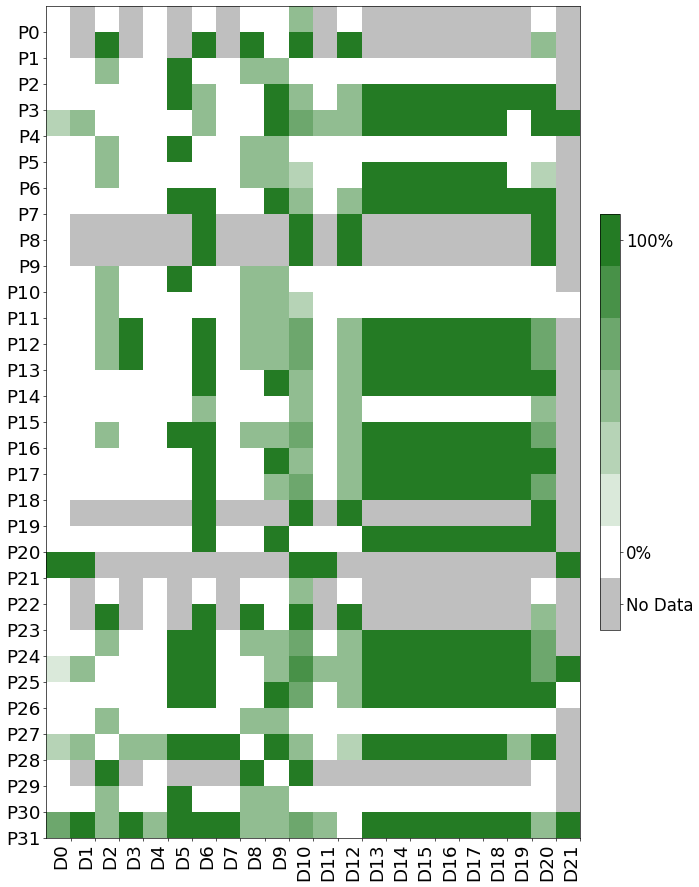

In [15]:
#Show 
'''
pipelineDict = getPipelinesIndexDict()    
datasetDict = getDatasetsIndexDict()    
for rowName in recommender_DF.index:
    for columnName in recommender_DF.columns:
         if (pipelineDict[rowName] == "P4") and ( datasetDict[columnName] == "D0"):
                print(recommender_DF.loc[rowName, columnName])
        #if ['FRACTION_RATE_SUCCESS_OVER_COMMENTED'] == 0: 
'''

percentageValues = []
def calculateSuccessPercentage(recommenderDataFrameItam):
    #global percentageValues, pipelineDict, datasetDict
    percentageValues = {-1: 0, 0.0: 1/7, 0.25: 2/7, 0.33: 3/7, 0.5: 4/7, 0.67: 5/7, 0.75: 6/7, 1.0: 7/7}
    
    
    result = 0
    if not recommenderDataFrameItam["EXPERT_COMMENTS"]: #If no comments
        result = -1
    else:
        result = recommenderDataFrameItam["EXPERT_COMMENTS"].count('+1')/len(recommenderDataFrameItam["EXPERT_COMMENTS"])
        #if result == 0:
        #    print("Result :\n", recommenderDataFrameItam, "\n\n")
            
    #if round(result, 2) not in percentageValues:
    #    percentageValues += [round(result, 2)]
    result = percentageValues[round(result, 2)]
    return result

def generateColormap(startRGB, stopRGB, numOfColors):
    startR, startG, startB = list(ImageColor.getcolor(startRGB, "RGB"))
    startR, startG, startB = list(ImageColor.getrgb(startRGB))
    stopR, stopG, stopB = list(ImageColor.getrgb(stopRGB))
    colorArray = []
    for i in range(numOfColors):
        colorArray += ['#%02x%02x%02x' % (int(startR + (stopR - startR) * i / numOfColors), int(startG + (stopG - startG) * i / numOfColors), int(startB + (stopB - startB) * i / numOfColors))]
    return colorArray
 
           
def successPercentageFigure_v4():    
    global percentageValues
    
    categorized_color_matplotlib = ['#bfbfbf', '#ffffff', '#006600'] 
    
    percentageValues = [-1, 0.0, 0.25, 0.33, 0.5, 0.67, 0.75, 1.0]
    categorized_color_matplotlib = ['#bfbfbf'] * 7 +  generateColormap('#ffffff', '#006600', 7) 
    categorized_color_matplotlib = ['#bfbfbf'] +  generateColormap('#ffffff', '#006600', 7) 
    #print("categorized_color_matplotlib : ", categorized_color_matplotlib)
    
    sampleFigure = showFigure_Mtplotlib_v4_For_Percentage(calculateSuccessPercentage,
                useIndex = True,
                colorScale = categorized_color_matplotlib, 
                result_DF_FN = os.path.join(outputsFolder, "Commented Success Percentage.csv"),
                colorbarTextPoints=[1/16, 3/16, 15/16],
                colorbarTexts=["No Data", "0%","100%"],
                colorbarTextRotation = 0)  
    #print("Percentage Values : ", sorted(percentageValues))
    
    percentageValues = [-1, 0.0, 0.25, 0.33, 0.5, 0.67, 0.75, 1.0]
    #print(type(sampleFigure))
    
    '''
    import matplotlib.pyplot as plt
    import matplotlib as mpl

    img, axe = plt.subplots(figsize=(6, 1))
    cmap = mpl.colors.ListedColormap(['red', 'green', 'blue', 'cyan'])
    bounds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    #norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    cb2 = mpl.colorbar.ColorbarBase(axe, cmap=cmap,
                                    #norm=norm,
                                    boundaries=bounds,
                                    #extend='both',
                                    ticks=bounds,
                                    spacing='proportional',
                                    orientation='horizontal')
    cb2.set_label('Discrete intervals, some other units')

    sampleFigure.colorbar(ax=ax)
    sampleFigure.axes[1] = img
    cbar = img
    #sampleFigure.colorbar(axe)
    sampleFigure.draw()
     '''
    
    #sampleFigure.tight_layout()
    #sampleFigure.savefig(os.path.join(figuresFolder,"Commented Success Percentage.png"))
    sampleFigure.savefig(os.path.join(figuresFolder,"Commented Success Percentage.pdf"))#, bbox_inches='tight'))
    #sampleFigure.show()
    
successPercentageFigure_v4()

In [16]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)


def exprtConfidenceSwarmPlot_v4():
    testConfidence = pd.read_csv(confidenceEvaluationReport_DF_FN)
    #fig, ax = plt.subplots()
    
    snsPlot = sns.boxplot(x="Status", y="Average expert confidence", data=testConfidence, boxprops={'facecolor':'None'})#, ax=ax)
    snsPlot = sns.swarmplot(x="Status", y="Average expert confidence", data=testConfidence,palette=sns.color_palette(['red', 'green']), zorder=.5)#, ax=ax)

    snsPlot.set(xlabel=None)
    snsPlot.set_yticklabels(['','Good','','','','','Advanced'])
    snsPlot.set_xticklabels(snsPlot.get_xmajorticklabels(),fontsize=15)
    snsPlot.set_yticklabels(snsPlot.get_ymajorticklabels(),fontsize=15)
    snsPlot.set_ylabel("Average expert confidence",fontsize=15)
    
    frame1 = plt.gca()
    '''
    for xlabel_i in frame1.axes.get_xticklabels():
        xlabel_i.set_visible(False)
        xlabel_i.set_fontsize(0.0)
    for xlabel_i in frame1.axes.get_yticklabels():
        xlabel_i.set_fontsize(0.0)
        xlabel_i.set_visible(False)
    for tick in frame1.axes.get_xticklines():
        tick.set_visible(False)'''
    for index, tick in enumerate(frame1.axes.get_yticklines()):
        if (index > 2) and (index < len(frame1.axes.get_yticklines()) - 4):
            tick.set_visible(False)
        else:
            tick.set_visible(True)
            
    #snsPlot.set_yticklabels(['Good','Advanced'])
    #snsPlot.yaxis.set_ticks_position('both')
    #snsPlot.yaxis.set_visible(False)
    
    plt.savefig(os.path.join(figuresFolder,'Confidence Swarm Experts.pdf'),bbox_inches = 'tight')
    #plt.savefig(os.path.join(figuresFolder,'Confidence Swarm Experts.png'),bbox_inches = 'tight')
    plt.show(block=False)
    plt.pause(1)
    plt.close()
    
    
    successDF = testConfidence.loc[testConfidence['Status'] == 'success']
    failDF = testConfidence.loc[testConfidence['Status'] == 'failed']

    successConfidences = successDF['Average expert confidence'].tolist()
    failConfidences = failDF['Average expert confidence'].tolist()

    #print(mean(successConfidences))
    #print(mean(failConfidences))

    stat, p = ttest_ind(failConfidences,successConfidences)
    #print('stat: ', stat)
    #print('p: ', p) #A p-value is the probability that the results from your sample data occurred by chance, In most cases, a p-value of 0.05 (5%) is accepted to mean the data is valid.
    
    print("exprtConfidenceSwarmPlot_v4 Done")
    
def exprtFractionSwarmPlot_v4():
    testConfidence = pd.read_csv(fractionRateReport_DF_FN)
    #fig, ax = plt.subplots()
    
    snsPlot = sns.boxplot(testConfidence["Status"], y="Fraction of experts", data=testConfidence, boxprops={'facecolor':'None'})#, ax=ax)
    snsPlot = sns.swarmplot(testConfidence["Status"], y="Fraction of experts", data=testConfidence,palette=sns.color_palette(['red', 'green']), zorder=.05)#, ax=ax)

    snsPlot.set(xlabel=None)
    #snsPlot.tick_params(labelsize=15)
    snsPlot.set_xticklabels(snsPlot.get_xmajorticklabels(),fontsize=15)

    snsPlot.set_ylabel("Fraction of experts",fontsize=15)
    
    plt.savefig(os.path.join(figuresFolder,'Fraction of experts.pdf'))
    #plt.savefig(os.path.join(figuresFolder,'Fraction of experts.png'))
    plt.show(block=False)
    plt.pause(1)
    plt.close()
    
    successDF = testConfidence.loc[testConfidence['Status'] == 'success']
    failDF = testConfidence.loc[testConfidence['Status'] == 'failed']

    successConfidences = successDF['Fraction of experts'].tolist()
    failConfidences = failDF['Fraction of experts'].tolist()

    #print(mean(successConfidences))
    #print(mean(failConfidences))

    stat, p = ttest_ind(failConfidences,successConfidences)
    #print('stat: ', stat)
    #print('p: ', p) #A p-value is the probability that the results from your sample data occurred by chance, In most cases, a p-value of 0.05 (5%) is accepted to mean the data is valid.
    
    print("confidenceSwarmPlot_v4 Done")


In [17]:
def TPR_FPR_experts(predictions):
    Posetive_class2 = predictions[predictions['Status'] == 'success']
    Negative_class1 = predictions[predictions['Status'] == 'failed']
    TP_df = predictions[(predictions['Status'] == 'success') & (predictions['pred_class'] == 'success')]
    FP_df = predictions[(predictions['Status'] == 'failed') & (predictions['pred_class'] == 'success')]
    TN_df = predictions[(predictions['Status'] == 'failed') & (predictions['pred_class'] == 'failed')]
    FN_df = predictions[(predictions['Status'] == 'success') & (predictions['pred_class'] == 'failed')]

    TPR = TP_df.shape[0]/Posetive_class2.shape[0]
    FPR = FP_df.shape[0]/Negative_class1.shape[0]
    return TPR,FPR


def allThresholds_experts(predictions):   # gets df of all predictions and the fraction of experts
    thre_TPR_FPR = pd.DataFrame(columns = ['threshold','avg_TPR','avg_FPR'])

    all_avg_TPR = []
    all_avg_FPR = []
    TPR_list = []
    FPR_list = []
    i = 0
    for threshold in np.arange(0,1.1,0.1):
        
        
        predictions.loc[predictions['Fraction of experts'] <= threshold, 'pred_class'] = 'failed'
        predictions.loc[predictions['Fraction of experts'] > threshold, 'pred_class'] = 'success'
        TPR,FPR = TPR_FPR_experts(predictions)
        TPR_list.append(TPR)
        FPR_list.append(FPR)
    return TPR_list,FPR_list

def TPR_FPR_recommender(predictions):
    
    type(predictions)
    Posetive_class2 = predictions.loc[predictions['status'] == 2]
    Negative_class1 = predictions.loc[predictions['status'] == 1]
    TP_df = predictions.loc[(predictions['status'] == 2) & (predictions['pred_class'] == 2)]
    FP_df = predictions.loc[(predictions['status'] == 1) & (predictions['pred_class'] == 2)]
    TN_df = predictions.loc[(predictions['status'] == 1) & (predictions['pred_class'] == 1)]
    FN_df = predictions.loc[(predictions['status'] == 2) & (predictions['pred_class'] == 1)]
    

    TPR = TP_df.shape[0]/Posetive_class2.shape[0]
    FPR = FP_df.shape[0]/Negative_class1.shape[0]
    return TPR,FPR


def allThresholds_recommender(allFoldsPredictions):#,minTh,maxTh):
    thre_TPR_FPR = pd.DataFrame(columns = ['threshold','avg_TPR','avg_FPR'])

    all_avg_TPR = []
    all_avg_FPR = []
    i = 0
    TPR_list = []
    FPR_list = []
    for threshold in np.arange(-0.1,2.4,0.1):
        allFoldsPredictions['pred_class'] = np.where(allFoldsPredictions['prediction'] > threshold, 2, 1)
        TPR,FPR = TPR_FPR_recommender(allFoldsPredictions)
        TPR_list.append(TPR)
        FPR_list.append(FPR)
    avg_TPR = sum(TPR_list)/len(TPR_list)
    all_avg_TPR.append(avg_TPR)
    avg_FPR = sum(FPR_list)/len(FPR_list)
    all_avg_FPR.append(avg_FPR)
    print("threshold", threshold,"avg_TPR",avg_TPR,"avg_FPR: ",avg_FPR)
    #thre_TPR_FPR = thre_TPR_FPR.append({'threshold':threshold,'avg_TPR': avg_TPR ,'avg_FPR': avg_FPR}, ignore_index = True)

    return TPR_list,FPR_list

def rocCurveEvaluation_v4():
    df = pd.read_csv(fractionRateReport_DF_FN)
    
    #fig, ax = plt.subplots()
    
    
    tpr,fpr = allThresholds_experts(df)
    AUC_experts = 0
    for i in range(len(tpr)-1):
        AUC_experts = AUC_experts + (((tpr[i]+tpr[i+1])/2) * (fpr[i]-fpr[i+1]))
    print(AUC_experts) 
    
    #https://github.com/matplotlib/matplotlib/issues/9460
    #colorlind codes : '006BA4', 'FF800E', 'ABABAB', '595959', '5F9ED1', 'C85200', '898989', 'A2C8EC', 'FFBC79', 'CFCFCF'
    plt.plot(fpr,tpr, color='#006BA4')
    plt.legend(loc='lower right')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

    #plt.savefig('thre_1-2.png')

    #plt.show(block=False)
    
    allPredictions = pd.read_csv(alsModel_FN)
    all_avg_TPR,all_avg_FPR = allThresholds_recommender(allPredictions)
    AUC = 0
    for i in range(len(all_avg_TPR)-1):
        AUC = AUC + (((all_avg_TPR[i]+all_avg_TPR[i+1])/2) * (all_avg_FPR[i]-all_avg_FPR[i+1]))
    print(AUC) 

    plt.plot(all_avg_FPR,all_avg_TPR, label='Recommender System', color='#B2182B')
    plt.plot(fpr,tpr, label='Experts', color='#EF8A62')
    plt.plot([0, 1], [0, 1], '--', label='Chance', color='#999999')
    #plt.plot([], [], '--', label='Chance', color='#FF800E')

    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], '--', label='Chance', color='#999999')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate',fontsize=14)
    plt.xlabel('False Positive Rate',fontsize=14)
    plt.plot(0.23, 0.81, marker='o', markersize=10,  color='#4D4D4D')
    
    plt.savefig(os.path.join(figuresFolder, "ROC Curve.pdf"))
    plt.show(block=False)
    plt.pause(1)
    plt.close()

    print("rocCurveEvaluation_v4 Done")


#rocCurveEvaluation_v4()   
    

In [18]:
#
def scientificRecommender_v4():
    concatenateExpertComments_v4() 
    addExpertsConfidence_v4()
    trimDataframe_v4()
    extractIndexTables_v4()
    addConfidenceRatings_v4()
    addExecutionResult_v4()
    generateConfidenceEvaluationReport_v4() 
    addFractionRates_v4() 
    
    generateAlsModelInput_v4()
    
    #This function generates statistic reports for Pipelines and Datasets based on fetched information from the server
    fetchPipelinesInfo_v4()            
    fetchDatasetsInfo_v4()            
    getPipelinesAndDatasetsStatisctics_v4() 

    fillRecommenderDataFrameStatistics_v4()
    pipelineExecutionFigure5_v4()
    pipelineExecutionFigure2_v4()
    successPercentageFigure_v4()

    exprtConfidenceSwarmPlot_v4()
    exprtFractionSwarmPlot_v4()

    rocCurveEvaluation_v4() 
    
#scientificRecommender_v4()

In [19]:
def showFigure_Mtplotlib_v4_(
    processingFunction, 
    useIndex = False,
    colorScale=[[0, "red"], [0.5 , "white"], [1, "green"]], 
    figureTitle=None,
    result_DF_FN = None,
    colorbarTextPoints = None,
    colorbarTexts = None,
    colorbarTextRotation = 0):
    

    global recommender_DF
    if recommender_DF.empty:
        loadRecommenderDataFrame()
    
    if not processingFunction:
        return
    
    temporary_DF = pd.DataFrame(index=recommender_DF.index.tolist(), columns=recommender_DF.columns.tolist())
    
    for rowName in recommender_DF.index:
        for columnName in recommender_DF.columns:
            #temporary_DF.loc[rowName, columnName] = 2 * processingFunction(recommender_DF.loc[rowName, columnName]) - 1  #Map (0, 1) to (-1, 1)
            temporary_DF.loc[rowName, columnName] = processingFunction(recommender_DF.loc[rowName, columnName])
    
    if useIndex is True:
        temporary_DF = indexDataFrame_v4(temporary_DF)
    
    if result_DF_FN:
        if '.xlsx' in result_DF_FN:
            temporary_DF.to_excel(result_DF_FN)
        elif '.csv' in result_DF_FN:
            temporary_DF.to_csv(
                result_DF_FN, 
                sep=',', 
                encoding='utf-8')

    temporary_DF = temporary_DF.astype(float)
    
    #figure = plt.figure(figsize=(20, 20))
    #figure, ax = plt.subplots(figsize=(18, 18))
    figure, ax = plt.subplots(figsize=(15, 18))
    
    ax = sns.heatmap(
        temporary_DF, 
        cmap=ListedColormap(colorScale), 
        vmin=0, 
        vmax=1, 
        #linewidths=.5,
        cbar=True,
        cbar_kws={
            'pad': 0.05, 
            #'orientation': 'horizontal',
            'orientation': 'vertical',
            "shrink": 0.5
        },
        ax = ax,
        square=True, #Square the tiles
        )
    
    
    cmap = ax.collections[0].cmap
    cmap.set_under('white')#Colour values less than vmin in white
    cmap.set_over('yellow')# colour valued larger than vmax in red
    
    #ax.set_aspect('equal') #Square the tiles
    
    if figureTitle:
        plt.title(title=figureTitle)
        
    plt.yticks(
        np.arange(0.5, len(temporary_DF.index), 1), 
        temporary_DF.index, 
        rotation = 0,
        fontsize=15)

    plt.xticks(
        np.arange(0.5, len(temporary_DF.columns), 1),
        temporary_DF.columns, 
        rotation = 90,
        fontsize=15)
    
    #Update colorbar
    if colorbarTextPoints and colorbarTexts:
        #Get access to colorbar
        cbar = ax.collections[0].colorbar
        
        #Set font size of colorbar
        #cbar.ax.tick_params(labelsize=18)

        #Set ticks of colorbar (Texts)
        #for index, item in enumerate(colorbarTextPoints):
        #    colorbarTextPoints[index] = 2 * colorbarTextPoints[index] - 1
        cbar.set_ticks(colorbarTextPoints)
        cbar.set_ticklabels(colorbarTexts)
        #cbar.ax.set_yticklabels(colorbarTexts, rotation = colorbarTextRotation)  #if 'orientation': 'vertical',
        cbar.ax.set_yticklabels(colorbarTexts, rotation = colorbarTextRotation, fontsize=15)  #if 'orientation': 'horizontal',
        #cbar.set(size="5%", pad=0.05)
        cmap = cbar.cmap
        
        cmap.set_under('white')#Colour values less than vmin in white
        cmap.set_over('yellow')# colour valued larger than vmax in red
    
    #plt.setp(ax.get_xticklabels(), horizontalalignment='right', fontsize='small')
    
    plt.show(block=False)
    plt.pause(1)
    plt.close()

    return figure

#pipelineExecutionFigure5_v4()

In [20]:
'''
successPercentageFigure_v4()

import matplotlib.pyplot as plt
import matplotlib as mpl

#fig, ax = plt.subplots(figsize=(6, 1))

fig = sampleFigure.add_subplot(1, 2, 2)

sampleFigure.subplots_adjust(right=0.5)

cmap = ax.collections[0].cmap
print(cmap)   


cmap = mpl.colors.ListedColormap(['red', 'green', 'blue', 'cyan'])
#cmap.set_over('0.25')
#cmap.set_under('0.75')

bounds = [0.5, 1]
#norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cb2 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                #norm=norm,
                                boundaries=bounds,
                                #extend='both',
                                ticks=bounds,
                                spacing='proportional',
                                orientation='horizontal')
cb2.set_label('Discrete intervals, some other units')
#sampleFigure.draw_wrapper()
'''

"\nsuccessPercentageFigure_v4()\n\nimport matplotlib.pyplot as plt\nimport matplotlib as mpl\n\n#fig, ax = plt.subplots(figsize=(6, 1))\n\nfig = sampleFigure.add_subplot(1, 2, 2)\n\nsampleFigure.subplots_adjust(right=0.5)\n\ncmap = ax.collections[0].cmap\nprint(cmap)   \n\n\ncmap = mpl.colors.ListedColormap(['red', 'green', 'blue', 'cyan'])\n#cmap.set_over('0.25')\n#cmap.set_under('0.75')\n\nbounds = [0.5, 1]\n#norm = mpl.colors.BoundaryNorm(bounds, cmap.N)\ncb2 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,\n                                #norm=norm,\n                                boundaries=bounds,\n                                #extend='both',\n                                ticks=bounds,\n                                spacing='proportional',\n                                orientation='horizontal')\ncb2.set_label('Discrete intervals, some other units')\n#sampleFigure.draw_wrapper()\n"

In [21]:
'''
import matplotlib.pyplot as plt
import matplotlib as mpl

img, axe = plt.subplots(figsize=(6, 1))
cmap = mpl.colors.ListedColormap(['red', 'green', 'blue', 'cyan'])
bounds = [0, 10]
#norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cb2 = mpl.colorbar.ColorbarBase(axe, cmap=cmap,
                                #norm=norm,
                                boundaries=bounds,
                                #extend='both',
                                ticks=bounds,
                                spacing='proportional',
                                orientation='horizontal')
cb2.set_label('Discrete intervals, some other units')
'''


"\nimport matplotlib.pyplot as plt\nimport matplotlib as mpl\n\nimg, axe = plt.subplots(figsize=(6, 1))\ncmap = mpl.colors.ListedColormap(['red', 'green', 'blue', 'cyan'])\nbounds = [0, 10]\n#norm = mpl.colors.BoundaryNorm(bounds, cmap.N)\ncb2 = mpl.colorbar.ColorbarBase(axe, cmap=cmap,\n                                #norm=norm,\n                                boundaries=bounds,\n                                #extend='both',\n                                ticks=bounds,\n                                spacing='proportional',\n                                orientation='horizontal')\ncb2.set_label('Discrete intervals, some other units')\n"